✅ Pipeline reloaded and ready to use.
✅ Dataset loaded.
✅ Data transformed using saved encoder and scaler.


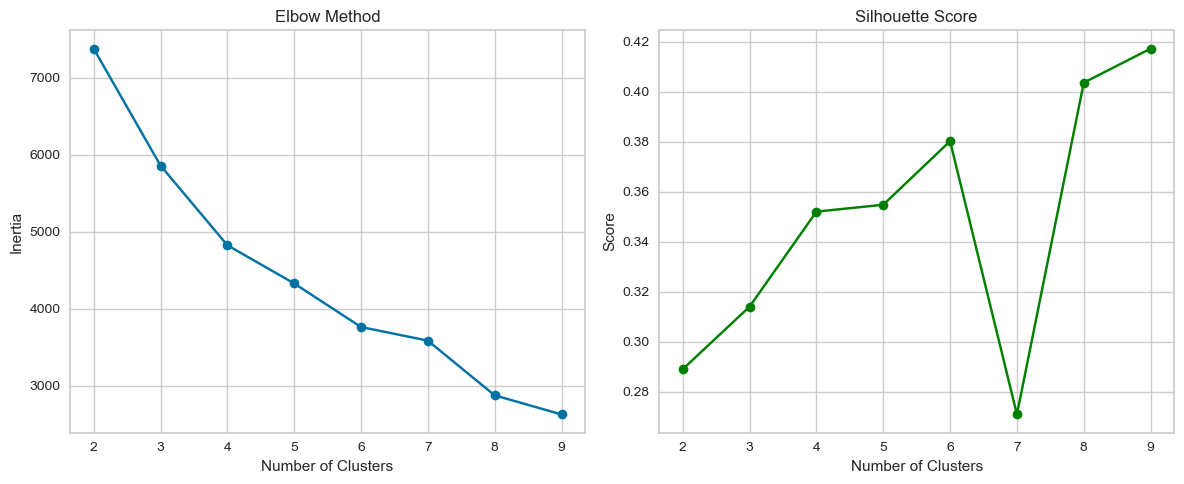


🔢 Clustering and silhouette scores for k=4,5,6:
✅ k=4: silhouette score = 0.3521
✅ k=5: silhouette score = 0.3548
✅ k=6: silhouette score = 0.3802


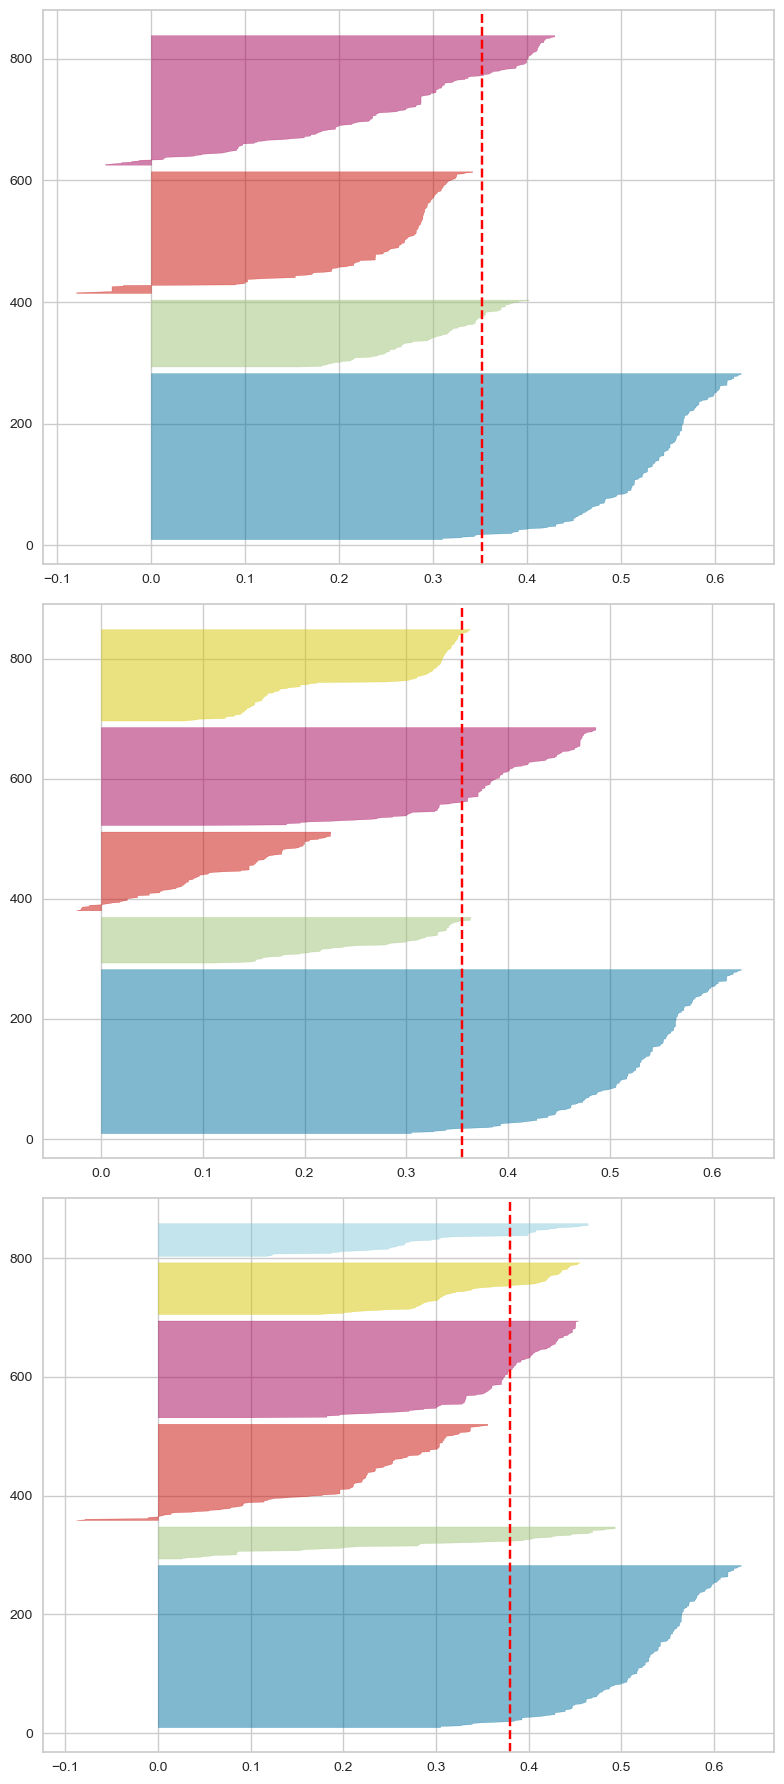

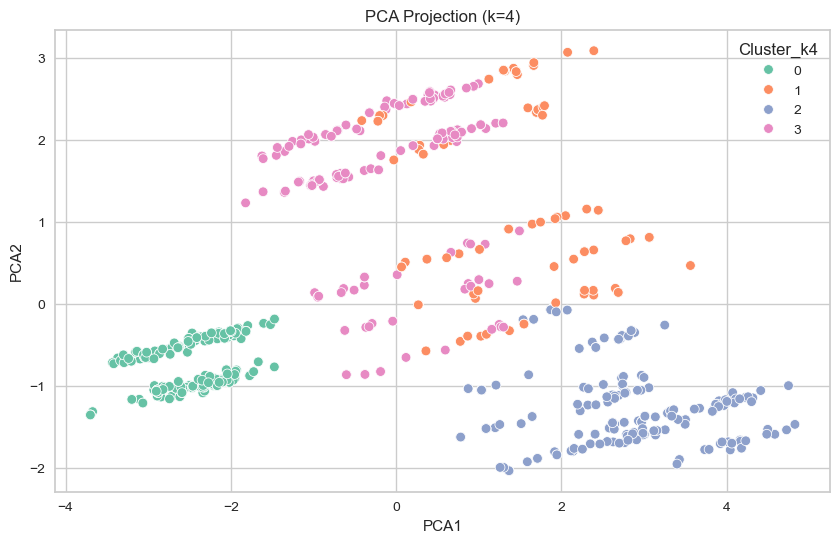

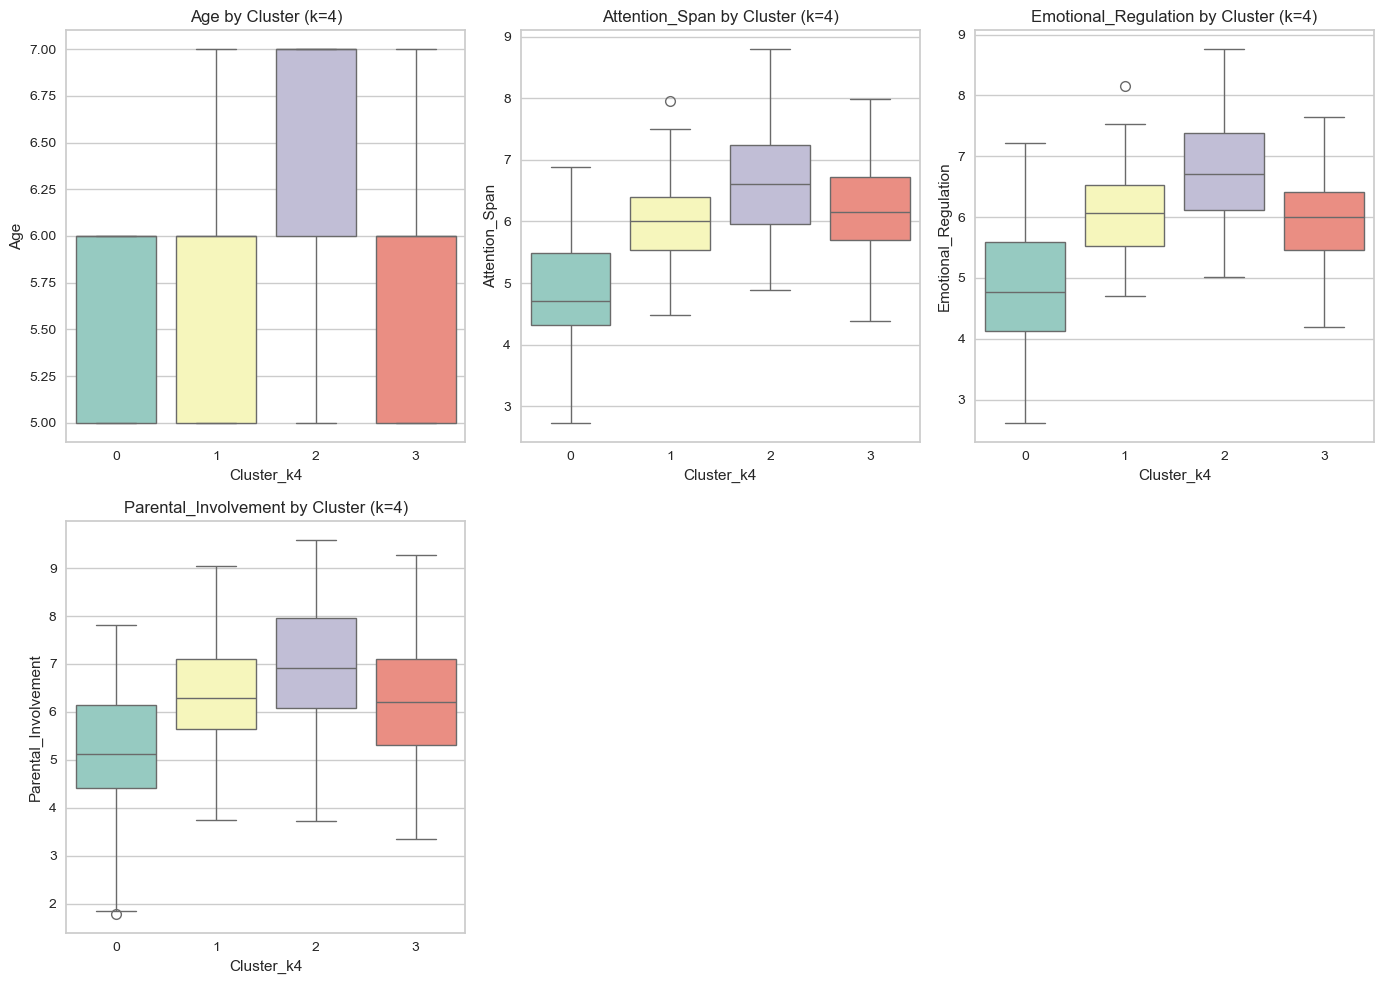


📊 One-way ANOVA results for numerical features (k=4):
Age: F = 70.85, p = 0.0000
Attention_Span: F = 235.14, p = 0.0000
Emotional_Regulation: F = 227.24, p = 0.0000
Parental_Involvement: F = 75.04, p = 0.0000
✅ Final dataset saved to clustered_output_final.csv
✅ Export complete. Files saved:
- clustered_output_final.csv
- encoder_backup.joblib
- scaler_backup.joblib
- kmeans_model_backup.joblib
- cluster_pipeline_backup.joblib


In [1]:
# ------------------ IMPORTS ------------------
!pip install yellowbrick --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import f_classif
from yellowbrick.cluster import SilhouetteVisualizer
import joblib
import warnings

warnings.filterwarnings("ignore")

# ------------------ LOAD PIPELINE ------------------
pipeline = joblib.load('cluster_pipeline_backup.joblib')
encoder = pipeline['encoder']
scaler = pipeline['scaler']
kmeans = pipeline['model']
print("✅ Pipeline reloaded and ready to use.")

# ------------------ STEP 0: LOAD & PREPROCESS DATA ------------------
df = pd.read_csv("C:/Users/satth/Desktop/S0/Simulated_Learner_Dataset.csv")
print("✅ Dataset loaded.")

categorical_cols = ['Motivation_Type', 'Learning_Style', 'Social_Interaction_Style']
numerical_cols = ['Age', 'Attention_Span', 'Emotional_Regulation', 'Parental_Involvement']

# Use saved encoder and scaler — do NOT re-fit
encoded = encoder.transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([df[numerical_cols].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
X_scaled = scaler.transform(X)
print("✅ Data transformed using saved encoder and scaler.")

# ------------------ STEP 1: ELBOW + SILHOUETTE DIAGNOSTICS ------------------
inertia, silhouette_scores = [], []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    inertia.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")

plt.tight_layout()
plt.savefig("clustering_diagnostics.png")
plt.show()

# ------------------ STEP 2: CLUSTERING FOR K = 4, 5, 6 ------------------
print("\n🔢 Clustering and silhouette scores for k=4,5,6:")
for k in [4, 5, 6]:
    model_k = KMeans(n_clusters=k, random_state=42)
    df[f"Cluster_k{k}"] = model_k.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, df[f"Cluster_k{k}"])
    print(f"✅ k={k}: silhouette score = {score:.4f}")

# ------------------ STEP 3: SILHOUETTE VISUALIZER ------------------
fig, axs = plt.subplots(3, 1, figsize=(8, 18))
for i, k in enumerate([4, 5, 6]):
    visualizer = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=42), ax=axs[i], colors='yellowbrick')
    visualizer.fit(X_scaled)
plt.tight_layout()
plt.savefig("silhouette_components_k4_k5_k6.png", dpi=300)
plt.show()

# ------------------ STEP 4: PCA PROJECTION ------------------
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)

df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_k4', palette='Set2')
plt.title("PCA Projection (k=4)")
plt.savefig("pca_clusters_k4.png", dpi=300)
plt.show()

# ------------------ STEP 5: BOXPLOTS BY CLUSTER (k=4) ------------------
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, len(numerical_cols)//2 + 1, i+1)
    sns.boxplot(x='Cluster_k4', y=col, data=df, palette='Set3')
    plt.title(f'{col} by Cluster (k=4)')
plt.tight_layout()
plt.savefig("boxplots_k4.png", dpi=300)
plt.show()

# ------------------ STEP 6: ANOVA TEST ------------------
print("\n📊 One-way ANOVA results for numerical features (k=4):")
for col in numerical_cols:
    f_stat, p_value = f_classif(df[[col]], df['Cluster_k4'])
    print(f"{col}: F = {f_stat[0]:.2f}, p = {p_value[0]:.4f}")

# ------------------ STEP 7: EXPORT FINAL DATA ------------------
df.to_csv("clustered_output_final.csv", index=False)
print("✅ Final dataset saved to clustered_output_final.csv")

# ------------------ STEP 8: EXPORT PIPELINE ------------------
joblib.dump(encoder, 'encoder_backup.joblib')
joblib.dump(scaler, 'scaler_backup.joblib')
joblib.dump(kmeans, 'kmeans_model_backup.joblib')  # This is your originally loaded model

# Optional: Save the full pipeline again
backup_pipeline = {
    'encoder': encoder,
    'scaler': scaler,
    'model': kmeans
}
joblib.dump(backup_pipeline, 'cluster_pipeline_backup.joblib')

print("✅ Export complete. Files saved:")
print("- clustered_output_final.csv")
print("- encoder_backup.joblib")
print("- scaler_backup.joblib")
print("- kmeans_model_backup.joblib")
print("- cluster_pipeline_backup.joblib")
